# V2: 俳句モデル - Attention重みヒートマップ

日本語俳句生成時のAttention機構の挙動を可視化し、モデルがどの文字に注目しているかを把握します。

## ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from model_analyzer import ModelAnalyzer, InferenceEngine

# Seabornのスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
import japanize_matplotlib  # 日本語表示を有効化

## ModelAnalyzerとInferenceEngineの初期化

In [2]:
# 俳句モデルの読み込み
analyzer = ModelAnalyzer('../haiku_orgparam_model.json')
engine = InferenceEngine(analyzer)

モデル読み込み完了: vocab_size=2345, n_layer=1, n_embd=16, block_size=16, n_head=4


## セクション1：入力情報

In [3]:
# 可視化対象テキスト（俳句の冒頭部分）
input_text = "春の海"
print(f"入力テキスト: {input_text}")

# トークン化
token_ids = [analyzer.BOS] + analyzer.tokenize(input_text)
print(f"\nトークン化結果:")
for i, token_id in enumerate(token_ids):
    if token_id == analyzer.BOS:
        char = '<BOS>'
    else:
        char = analyzer.uchars[token_id]
    print(f"  位置 {i}: '{char}' (ID: {token_id})")

入力テキスト: 春の海

トークン化結果:
  位置 0: '<BOS>' (ID: 2344)
  位置 1: '春' (ID: 897)
  位置 2: 'の' (ID: 46)
  位置 3: '海' (ID: 1169)


## セクション2：全ヘッドのAttention重みヒートマップ

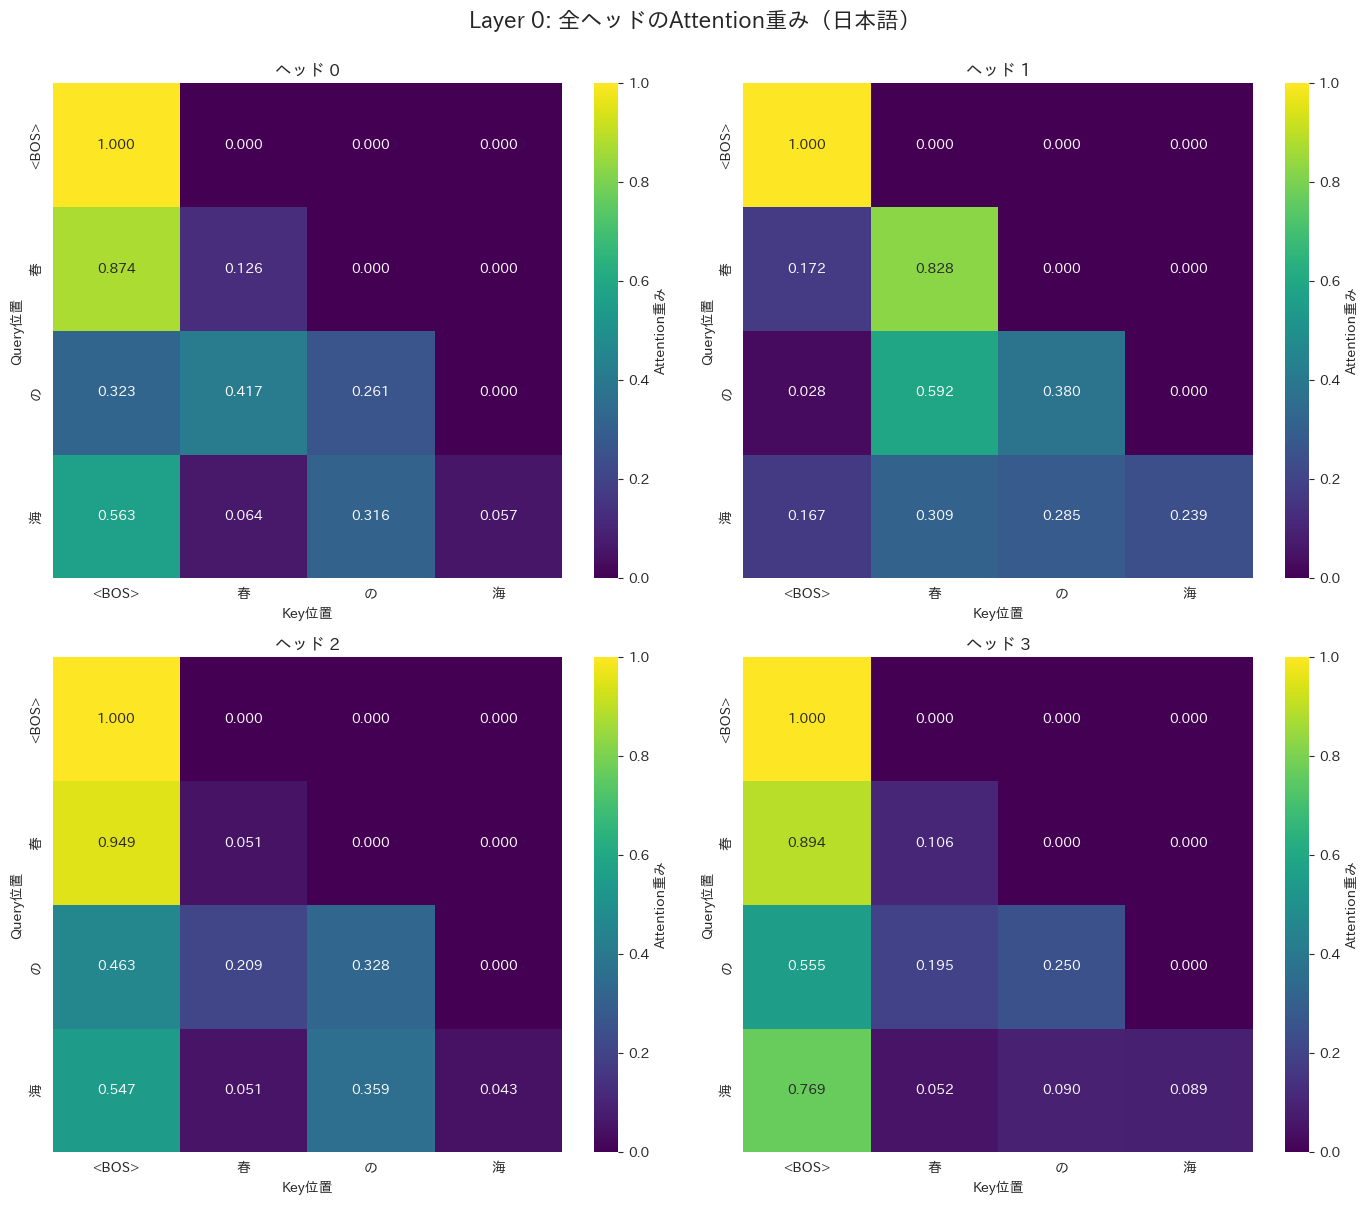


注: 対角線より上はcausal maskにより0になります（未来の文字には注目できない）


In [4]:
# Attention重みを計算
layer_idx = 0
attn_weights = engine.compute_attention_for_sequence(token_ids)

# レイヤー0の全ヘッドを取得
attn_layer0 = attn_weights[layer_idx]  # shape: (n_head, seq_len, seq_len)

# トークンラベルを作成
token_labels = []
for token_id in token_ids:
    if token_id == analyzer.BOS:
        token_labels.append('<BOS>')
    else:
        token_labels.append(analyzer.uchars[token_id])

# 4ヘッドを2x2で並べて表示
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for h in range(analyzer.n_head):
    ax = axes[h]
    
    # ヒートマップを描画
    sns.heatmap(
        attn_layer0[h],
        annot=True,
        fmt='.3f',
        cmap='viridis',
        xticklabels=token_labels,
        yticklabels=token_labels,
        cbar_kws={'label': 'Attention重み'},
        ax=ax,
        vmin=0,
        vmax=1
    )
    
    ax.set_title(f'ヘッド {h}')
    ax.set_xlabel('Key位置')
    ax.set_ylabel('Query位置')

plt.suptitle(f'Layer {layer_idx}: 全ヘッドのAttention重み（日本語）', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

print("\n注: 対角線より上はcausal maskにより0になります（未来の文字には注目できない）")

## セクション3：Plotlyインタラクティブヒートマップ

In [5]:
# 各ヘッドごとにインタラクティブヒートマップを作成
for h in range(analyzer.n_head):
    fig = go.Figure(data=go.Heatmap(
        z=attn_layer0[h],
        x=token_labels,
        y=token_labels,
        colorscale='Viridis',
        colorbar=dict(title='Attention重み'),
        hovertemplate='Query: %{y}<br>Key: %{x}<br>重み: %{z:.4f}<extra></extra>'
    ))
    
    fig.update_layout(
        title=f'Layer {layer_idx}, ヘッド {h} - Attention重み（インタラクティブ・日本語）',
        xaxis_title='Key位置',
        yaxis_title='Query位置',
        width=600,
        height=600
    )
    
    fig.show()

## セクション4：特定ヘッドの詳細分析

ヘッド 0 の詳細分析
位置 0 ('<BOS>'): 最も注目 → 位置 0 ('<BOS>'), 重み=1.0000
  全重み分布: ['1.000']

位置 1 ('春'): 最も注目 → 位置 0 ('<BOS>'), 重み=0.8735
  全重み分布: ['0.874', '0.126']

位置 2 ('の'): 最も注目 → 位置 1 ('春'), 重み=0.4167
  全重み分布: ['0.323', '0.417', '0.261']

位置 3 ('海'): 最も注目 → 位置 0 ('<BOS>'), 重み=0.5628
  全重み分布: ['0.563', '0.064', '0.316', '0.057']



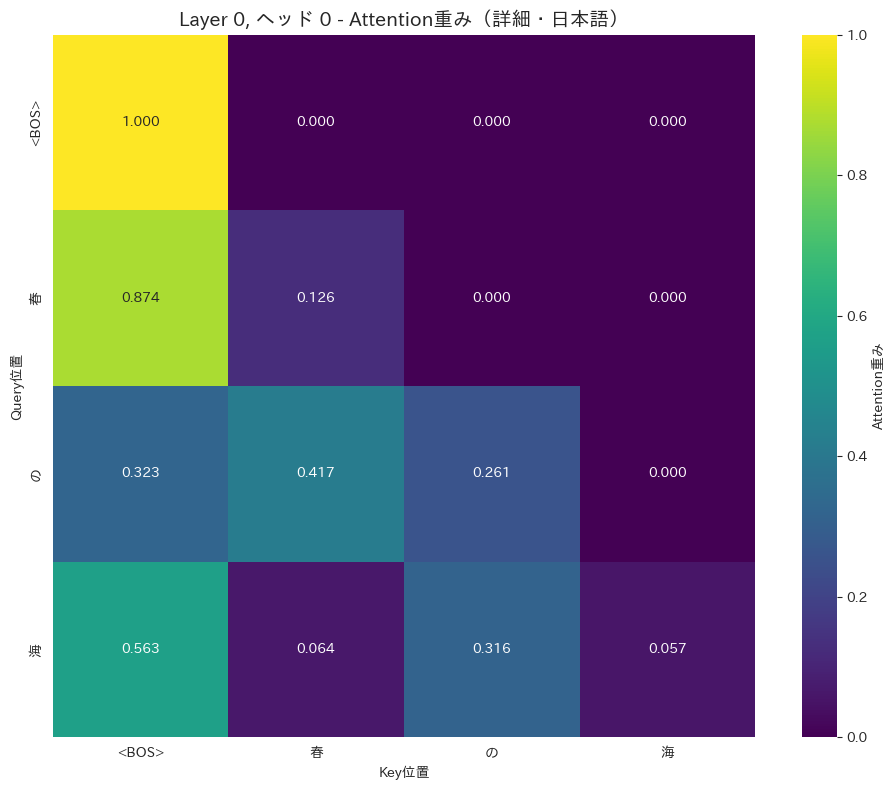

In [6]:
# 最も特徴的なパターンを示すヘッドを選択（ヘッド0を例に）
selected_head = 0

print(f"ヘッド {selected_head} の詳細分析")
print("=" * 50)

# 各位置で最も注目している位置を表示
for query_pos in range(len(token_labels)):
    attn_weights_at_pos = attn_layer0[selected_head][query_pos]
    
    # 非ゼロの重みのみを考慮（causal maskを除外）
    valid_positions = [(i, w) for i, w in enumerate(attn_weights_at_pos) if w > 0]
    
    if valid_positions:
        # 最も重みが大きい位置
        max_pos, max_weight = max(valid_positions, key=lambda x: x[1])
        
        print(f"位置 {query_pos} ('{token_labels[query_pos]}'): "
              f"最も注目 → 位置 {max_pos} ('{token_labels[max_pos]}'), 重み={max_weight:.4f}")
        
        # 重み分布を表示
        print(f"  全重み分布: {[f'{w:.3f}' for w in attn_weights_at_pos[:query_pos+1]]}")
    
    print()

# 大きなヒートマップで表示
plt.figure(figsize=(10, 8))
sns.heatmap(
    attn_layer0[selected_head],
    annot=True,
    fmt='.3f',
    cmap='viridis',
    xticklabels=token_labels,
    yticklabels=token_labels,
    cbar_kws={'label': 'Attention重み'},
    vmin=0,
    vmax=1,
    square=True
)
plt.title(f'Layer {layer_idx}, ヘッド {selected_head} - Attention重み（詳細・日本語）', fontsize=14)
plt.xlabel('Key位置')
plt.ylabel('Query位置')
plt.tight_layout()
plt.show()

## まとめ

このNotebookでは、日本語俳句生成時のAttention機構の挙動を可視化しました：

- 各ヘッドは異なるパターンで過去の文字に注目する
- Causal maskにより、未来の文字には注目できない（上三角が0）
- 日本語文字（ひらがな、漢字）に対するAttentionパターンを確認
- インタラクティブな可視化により、詳細な重みの値を確認可能

次のNotebookでは、日本語文字のEmbedding空間の分布を可視化します。